# Preprocessing steps for _MUON_ models

In [1]:
LOCAL = True
SAMPLE = "2016MU"

## Technologies and libraries

On top of the standard Python echosystem we are using:
 * `uproot` to convert data from `ROOT TTrees` to `pandas DataFrames`
 * `dask DataFrame` to enable processing datasets larger than the available RAM. Dask takes care of flushing from disk to RAM the data, converting from ROOT to pandas data format on demand.
 * `Arrow Feather` data format to cache in local storage the training dataset
     * Note that custom wrappers to Dask and TensorFlow, as defined in `feather_io.py` are needed 

In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as ddf
import uproot
from os import environ

## Loading data

In [3]:
from glob import glob

if LOCAL:
    if SAMPLE == "2016MU":
        file_pattern = "/afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root"
    else:
        pass
else:
    # file_pattern = "/workarea/cloud-storage/anderlinil/LamarrBenderTrain/j109/*.root"
    pass

default_file_list = glob(file_pattern)
file_list = environ.get("INPUT_FILES", " ".join(default_file_list)).split(" ")

print (f"Found {len(file_list)} files from {file_pattern}")  

Found 236 files from /afs/cern.ch/user/l/landerli/gangadir/workspace/landerli/LocalXML/109/*/output/*.root


### Conversion from `ROOT TTree` to `Pandas DataFrame`

In [4]:
def read_root(filename, tree=None):
    if tree is None:
        return uproot.open(filename)
    
    return pd.DataFrame(uproot.open(filename)[tree].arrays(library='np'))

In [5]:
selections = [
  "probe_Brunel_P > 3000",
  "probe_Brunel_P < 200000", 
  "probe_Brunel_ETA > 1.5", 
  "probe_Brunel_ETA < 5.5", 
  "probe_Brunel_isMuon == 1", 
  "probe_Brunel_MuonMuLL > -9",
  "probe_Brunel_MuonBgLL > -9", 
  "probe_Brunel_MuonMuLL <  1", 
  "probe_Brunel_MuonBgLL <  1", 
  "nTracks_Brunel > 0", 
  "nTracks_Brunel < 1000", 
  "probe_Brunel_MuonUnbiased == 1",
]

cuts = " and ".join([s for s in selections])

In [6]:
from functools import partial

sim = dict()
particles = ["muon", "pion", "kaon", "proton"]

for part in particles:
    sim[part] = (
        ddf.from_map(
            partial(read_root, tree=f"PidTupler/pid_{part}"),
            file_list,
        ).query(cuts)
    )

### List of features

In [7]:
from IPython.display import HTML

HTML ("<UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in sim["muon"].columns) + "</UL>")

## Features

In [8]:
for part in particles:
    sim[part]["p_GeV"] = sim[part].probe_Brunel_P/1e3
    # sim[part]["log10_p"] = np.log10(sim[part].probe_Brunel_P)
    sim[part]["eta"] = sim[part].probe_Brunel_ETA
    sim[part] = sim[part].map_partitions(lambda df: df.assign(nTracks_f = df.nTracks_Brunel + np.random.uniform(-0.5, 0.5, len(df))))
    sim[part]["charge"] = sim[part].probe_Brunel_trackcharge
    
    sim[part]["MuonMuLL"] = sim[part].probe_Brunel_MuonMuLL
    sim[part]["MuonBgLL"] = sim[part].probe_Brunel_MuonBgLL

In [9]:
real_conditions = ["p_GeV", "eta", "nTracks_f"]
flag_conditions = ["charge"]

conditions = real_conditions + flag_conditions
target = ["MuonMuLL", "MuonBgLL"]

In [41]:
from IPython.display import HTML

def list_vars(title, var_list):
    display(HTML (f"<P><B>{title}</B><UL>" + "\n".join(f"<LI> <PRE>{var}</PRE> " for var in var_list) + "</UL><HR>"))

list_vars("Input features (real)", real_conditions)
list_vars("Input features (boolean)", flag_conditions)
list_vars("Output features (real)", target)

In [11]:
dfs = dict()

for part in particles:
    dfs[part] = sim[part][conditions + target].head(500_000, npartitions=100)
    print(f"Number of {part}s:", len(dfs[part]))

Number of muons: 500000
Number of pions: 500000
Number of kaons: 500000
Number of protons: 500000


### Histograms

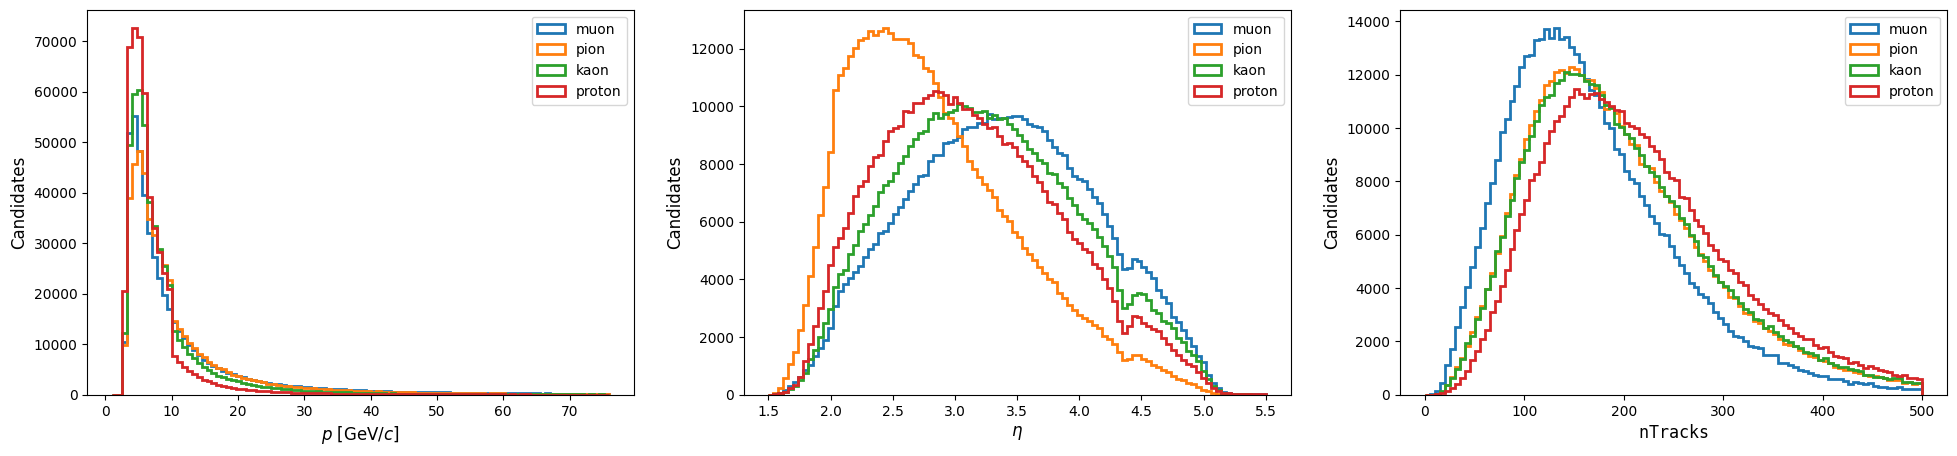

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel("$p$ [GeV/$c$]", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["p_GeV"], bins=np.linspace(1.0, 76.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(1, 3, 2)
plt.xlabel("$\eta$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["eta"], bins=np.linspace(1.5, 5.5, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.subplot(1, 3, 3)
plt.xlabel("$\mathtt{nTracks}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["nTracks_f"], bins=np.linspace(0.0, 500.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.show()

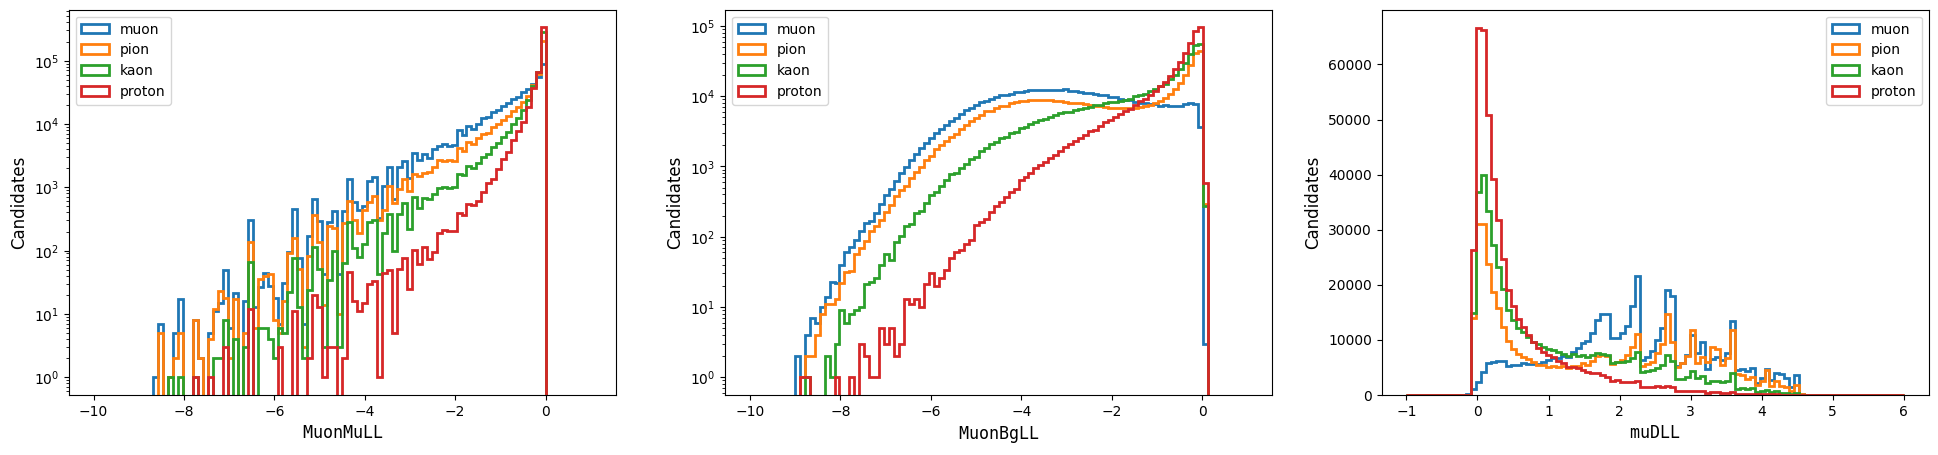

In [13]:
plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel("$\mathtt{MuonMuLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["MuonMuLL"], bins=np.linspace(-10.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(1, 3, 2)
plt.xlabel("$\mathtt{MuonBgLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["MuonBgLL"], bins=np.linspace(-10.0, 1.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)
plt.yscale("log")

plt.subplot(1, 3, 3)
plt.xlabel("$\mathtt{muDLL}$", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
for part in particles:
    plt.hist(dfs[part]["MuonMuLL"] - dfs[part]["MuonBgLL"], bins=np.linspace(-1.0, 6.0, 101), histtype="step", lw=2, label=part)
plt.legend(fontsize=10)

plt.show()

## Preprocessing

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, StandardScaler

n_features = len(real_conditions)
n_flags = len(flag_conditions)
n_target = len(target)

prep_step_x = dict()
for part in particles:
    prep_step_x[part] = ColumnTransformer(
        [
            ('features', QuantileTransformer(output_distribution='normal'), np.arange(n_features)),
            ('flags', "passthrough", n_features + np.arange(n_flags)),
        ]
    ).fit(dfs[part][conditions].values)

prep_step_y = dict()
for part in particles:
    prep_step_y[part] = StandardScaler().fit(dfs[part][target].values)

In [15]:
from preprocessing_utils import store_as_pickle

for part in particles:
    display(
        store_as_pickle(
            prep_step_x[part],
            f"MUON_{part.upper()}_PREPROCESSING_X",
            f"/home/mabarbet/PythonFastSim/models/Muon_{part}_models/tX_{SAMPLE}.pkl",
        )
    )
    display(
        store_as_pickle(
            prep_step_y[part],
            f"MUON_{part.upper()}_PREPROCESSING_Y",
            f"/home/mabarbet/PythonFastSim/models/Muon_{part}_models/tY_{SAMPLE}.pkl",
        )
    )

2023-12-27 16:48:26.538709: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 16:48:26.538757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 16:48:26.538786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 16:48:26.550028: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train, test and validation

The dataset is split in:
 * *train* (50%) used for training the model
 * *test* (40%) used for measuring the performance of the model
 * *validation* (10%) used in combination with the train dataset to check for overtraining effects
 
Split data is stored on disk in chunks of 100 MB (before compression).

In [16]:
DATA_PATH = "/home/mabarbet/PythonFastSim/data" if LOCAL else "/workarea/cloud-storage/mabarbet/data"

### Muons

In [17]:
from preprocessing_utils import split_and_store

entries = split_and_store(
    sim["muon"][conditions + target],
    [
        (0.5, environ.get("MUON_MUON_TRAIN", f"{DATA_PATH}/Muon-muon-{SAMPLE}-train")),
        (0.4, environ.get("MUON_MUON_TEST", f"{DATA_PATH}/Muon-muon-{SAMPLE}-test")),
        (0.1, environ.get("MUON_MUON_VALIDATION", f"{DATA_PATH}/Muon-muon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions,
    labels=target,
    preprocessorX=prep_step_x["muon"],
    preprocessorY=prep_step_y["muon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/Muon-muon-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/Muon-muon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/Muon-muon-2016MU-validation


,0
Train,11920169
Test,9531044
Validation,2385794


In [18]:
from feather_io import FeatherReader    

reader_train =  FeatherReader(environ.get("MUON_MUON_TRAIN", f"{DATA_PATH}/Muon-muon-{SAMPLE}-train"), max_files=3)
ds_train_mu = reader_train.as_tf_dataset()

In [19]:
X_mu, y_mu = next(iter(ds_train_mu.batch(2_000_000)))
X_mu.shape, y_mu.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 2]))

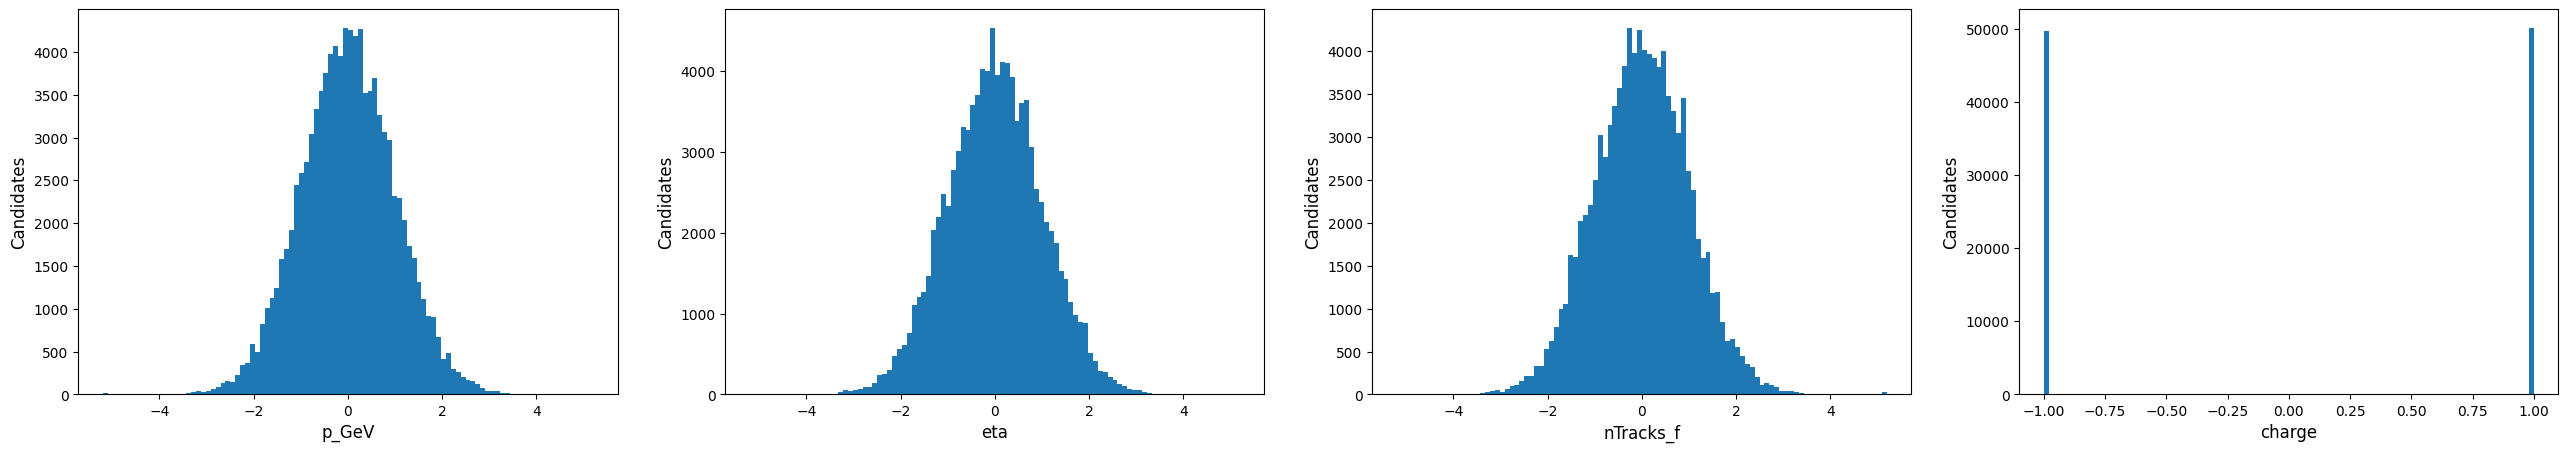

In [20]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(conditions):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_mu[:, i].numpy()[:100000], bins=100)

plt.show()

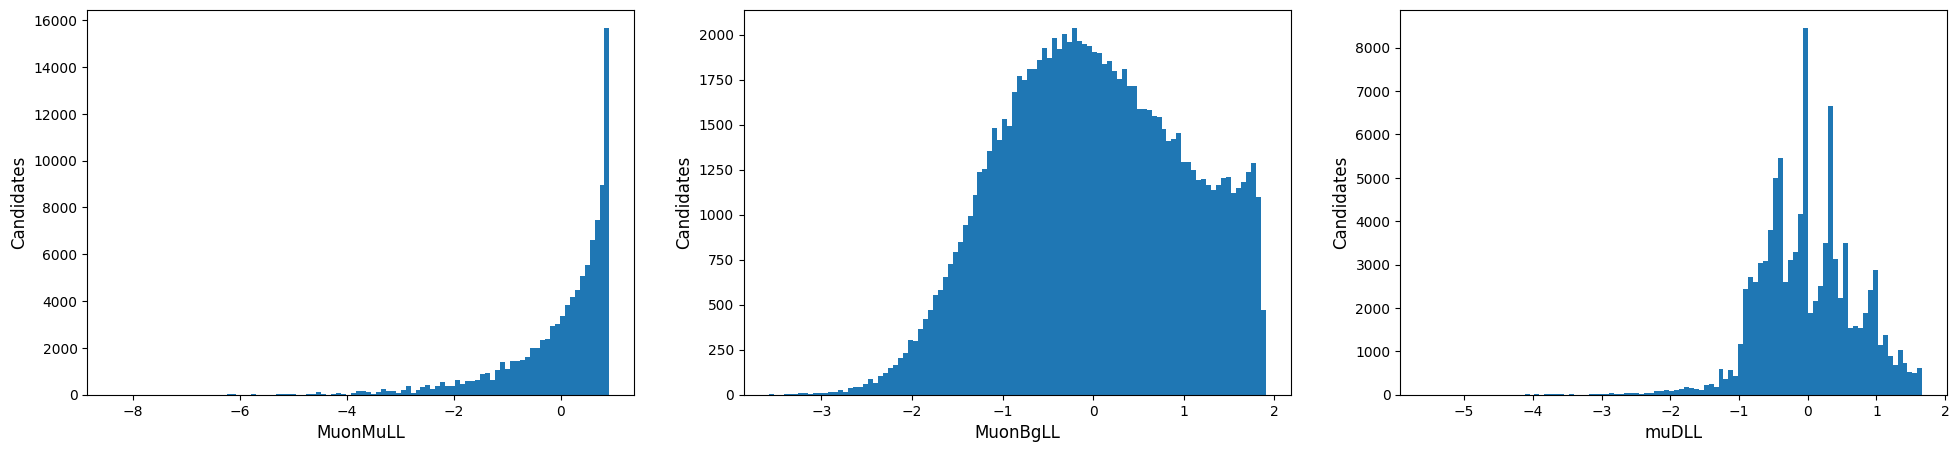

In [21]:
plt.figure(figsize=(24, 5), dpi=100)

for i, y_var in enumerate(target):
    plt.subplot(1, 3, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_mu[:, i].numpy()[:100000], bins=100)

plt.subplot(1, 3, 3)
plt.xlabel("muDLL", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_mu[:, 0].numpy()[:100000] - y_mu[:, 1].numpy()[:100000], bins=100)

plt.show()

In [22]:
np.savez_compressed(
    file=f"{DATA_PATH}/Muon-muon-{SAMPLE}-trainset.npz",
    x=X_mu.numpy(),
    x_vars=conditions,
    y=y_mu.numpy(),
    y_vars=target,
    w=None,
    w_var=None,
)

### Pions

In [23]:
entries = split_and_store(
    sim["pion"][conditions + target],
    [
        (0.5, environ.get("MUON_PION_TRAIN", f"{DATA_PATH}/Muon-pion-{SAMPLE}-train")),
        (0.4, environ.get("MUON_PION_TEST", f"{DATA_PATH}/Muon-pion-{SAMPLE}-test")),
        (0.1, environ.get("MUON_PION_VALIDATION", f"{DATA_PATH}/Muon-pion-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions,
    labels=target,
    preprocessorX=prep_step_x["pion"],
    preprocessorY=prep_step_y["pion"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/Muon-pion-2016MU-train
Processing /home/mabarbet/PythonFastSim/data/Muon-pion-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/Muon-pion-2016MU-validation


,0
Train,1303815
Test,1043793
Validation,261394


In [24]:
reader_train =  FeatherReader(environ.get("MUON_PION_TRAIN", f"{DATA_PATH}/Muon-pion-{SAMPLE}-train"), max_files=5)
ds_train_pi = reader_train.as_tf_dataset()

In [25]:
X_pi, y_pi = next(iter(ds_train_pi.batch(2_000_000)))
X_pi.shape, y_pi.shape

(TensorShape([1303817, 4]), TensorShape([1303817, 2]))

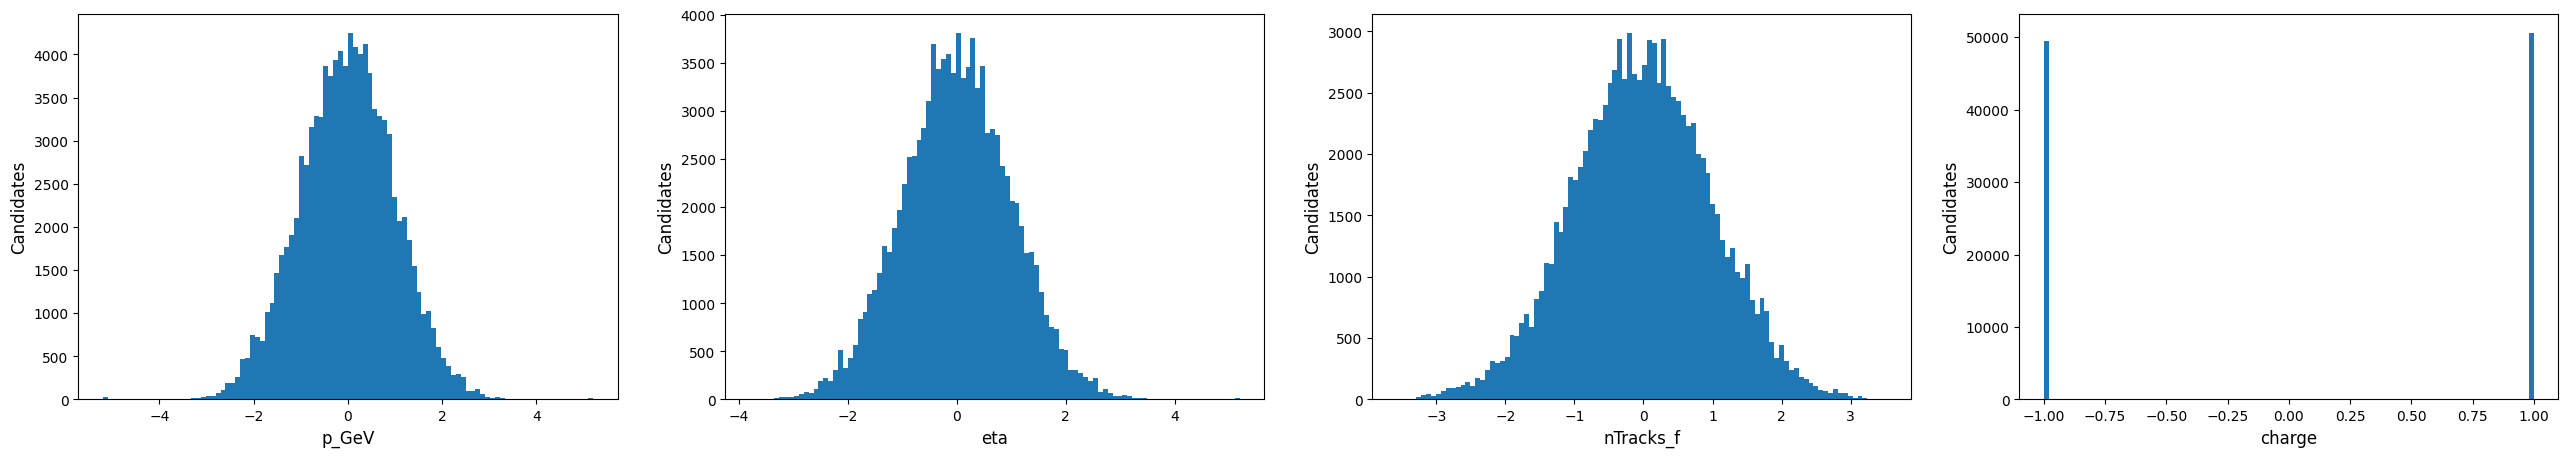

In [26]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(conditions):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_pi[:, i].numpy()[:100000], bins=100)

plt.show()

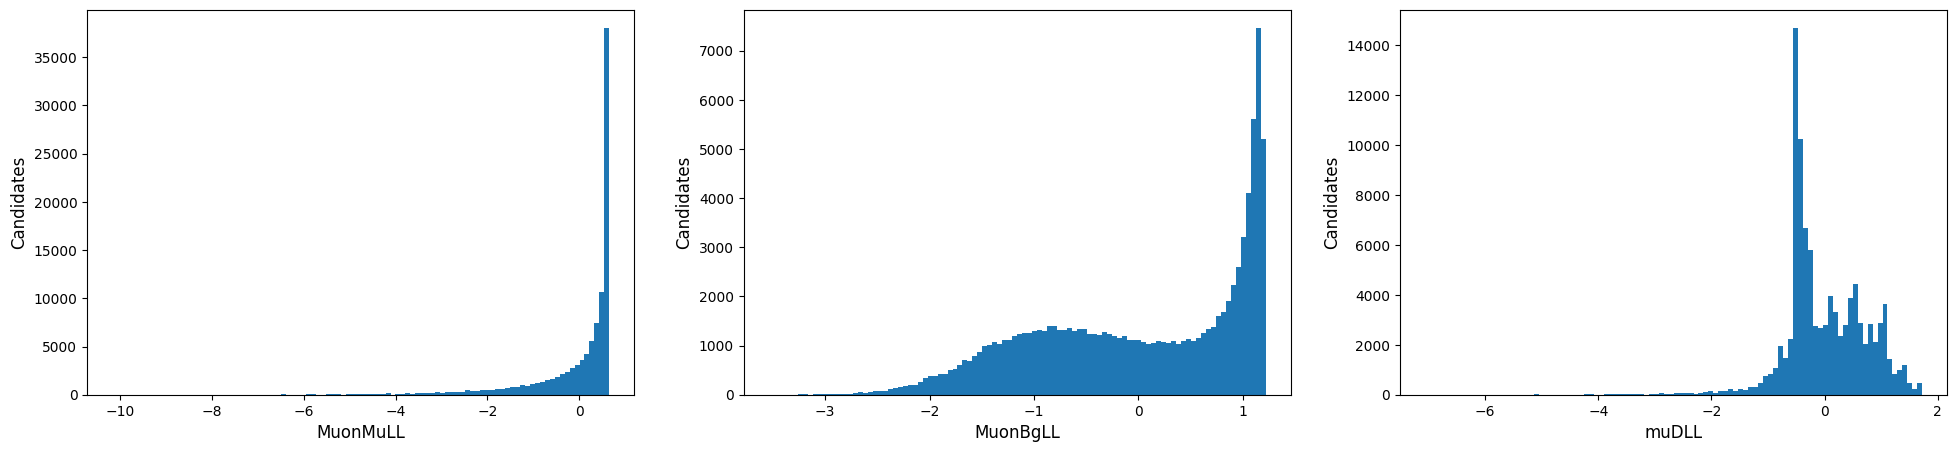

In [27]:
plt.figure(figsize=(24, 5), dpi=100)

for i, y_var in enumerate(target):
    plt.subplot(1, 3, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_pi[:, i].numpy()[:100000], bins=100)

plt.subplot(1, 3, 3)
plt.xlabel("muDLL", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_pi[:, 0].numpy()[:100000] - y_pi[:, 1].numpy()[:100000], bins=100)

plt.show()

In [28]:
np.savez_compressed(
    file=f"{DATA_PATH}/Muon-pion-{SAMPLE}-trainset.npz",
    x=X_pi.numpy(),
    x_vars=conditions,
    y=y_pi.numpy(),
    y_vars=target,
    w=None,
    w_var=None,
)

### Kaons

In [29]:
entries = split_and_store(
    sim["kaon"][conditions + target],
    [
        (0.5, environ.get("MUON_KAON_TRAIN", f"{DATA_PATH}/Muon-kaon-{SAMPLE}-train")),
        (0.4, environ.get("MUON_KAON_TEST", f"{DATA_PATH}/Muon-kaon-{SAMPLE}-test")),
        (0.1, environ.get("MUON_KAON_VALIDATION", f"{DATA_PATH}/Muon-kaon-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions,
    labels=target,
    preprocessorX=prep_step_x["kaon"],
    preprocessorY=prep_step_y["kaon"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/Muon-kaon-2016MU-train


Processing /home/mabarbet/PythonFastSim/data/Muon-kaon-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/Muon-kaon-2016MU-validation


,0
Train,3876944
Test,3103025
Validation,776215


In [30]:
reader_train =  FeatherReader(environ.get("MUON_KAON_TRAIN", f"{DATA_PATH}/Muon-kaon-{SAMPLE}-train"), max_files=3)
ds_train_k = reader_train.as_tf_dataset()

In [31]:
X_k, y_k = next(iter(ds_train_k.batch(2_000_000)))
X_k.shape, y_k.shape

(TensorShape([2000000, 4]), TensorShape([2000000, 2]))

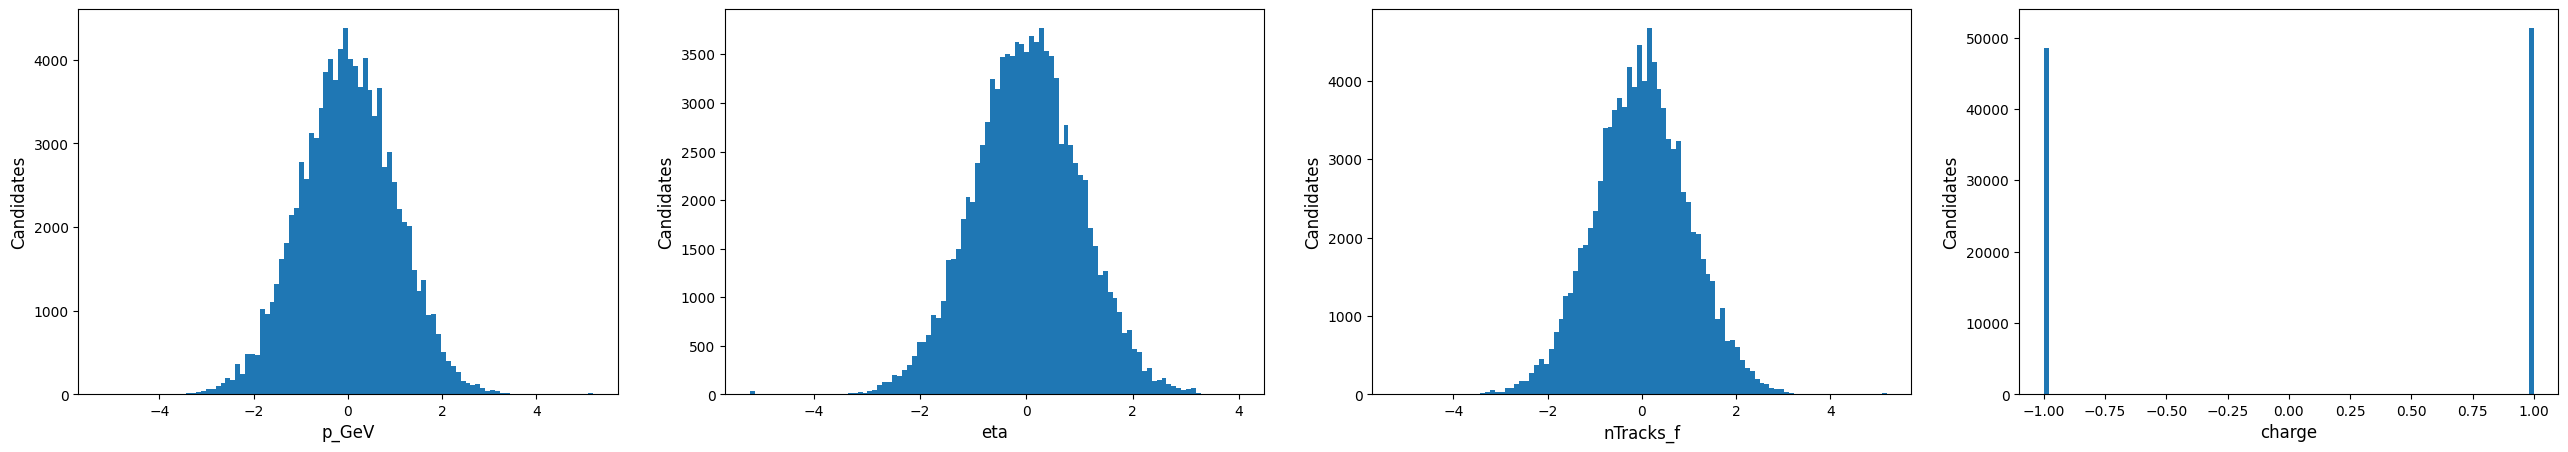

In [32]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(conditions):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_k[:, i].numpy()[:100000], bins=100)

plt.show()

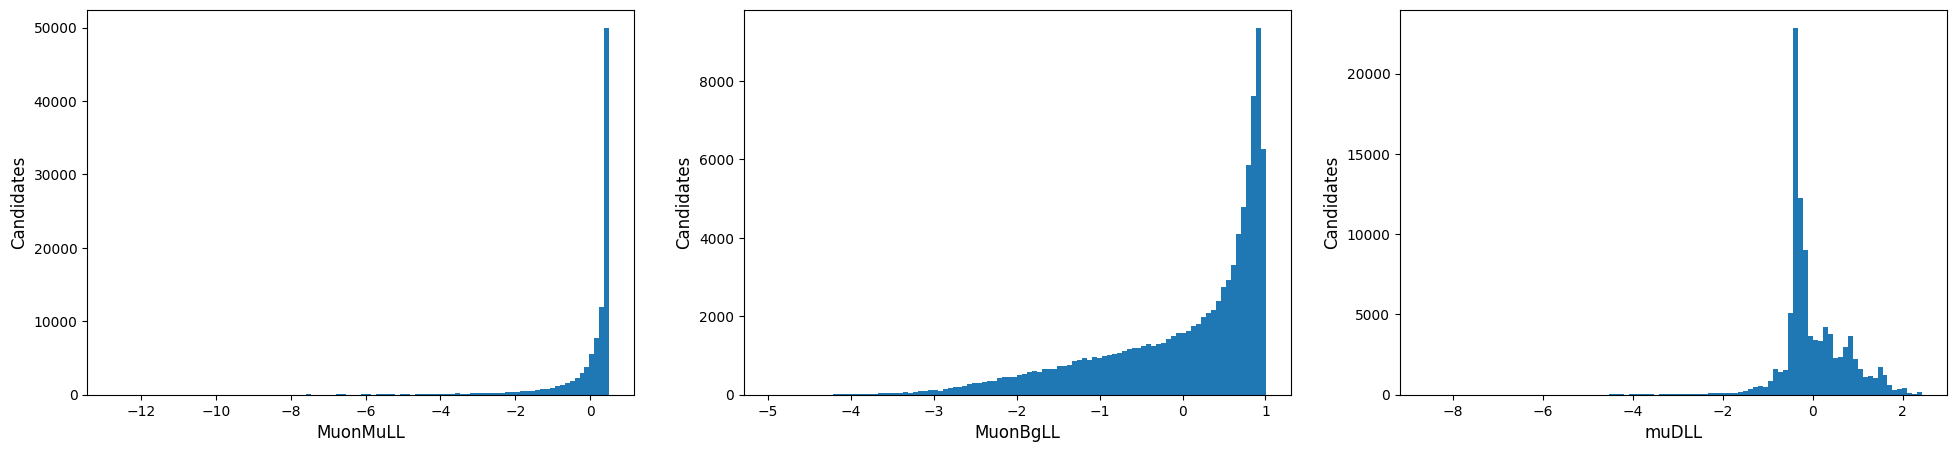

In [33]:
plt.figure(figsize=(24, 5), dpi=100)

for i, y_var in enumerate(target):
    plt.subplot(1, 3, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_k[:, i].numpy()[:100000], bins=100)

plt.subplot(1, 3, 3)
plt.xlabel("muDLL", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_k[:, 0].numpy()[:100000] - y_k[:, 1].numpy()[:100000], bins=100)

plt.show()

In [34]:
np.savez_compressed(
    file=f"{DATA_PATH}/Muon-kaon-{SAMPLE}-trainset.npz",
    x=X_k.numpy(),
    x_vars=conditions,
    y=y_k.numpy(),
    y_vars=target,
    w=None,
    w_var=None,
)

### Protons

In [35]:
entries = split_and_store(
    sim["proton"][conditions + target],
    [
        (0.5, environ.get("MUON_PROTON_TRAIN", f"{DATA_PATH}/Muon-proton-{SAMPLE}-train")),
        (0.4, environ.get("MUON_PROTON_TEST", f"{DATA_PATH}/Muon-proton-{SAMPLE}-test")),
        (0.1, environ.get("MUON_PROTON_VALIDATION", f"{DATA_PATH}/Muon-proton-{SAMPLE}-validation"))
    ],
    chunksize="100MB",
    features=conditions,
    labels=target,
    preprocessorX=prep_step_x["proton"],
    preprocessorY=prep_step_y["proton"],
)
    
pd.DataFrame(entries, index=["Train", "Test", "Validation"])

Processing /home/mabarbet/PythonFastSim/data/Muon-proton-2016MU-train


Processing /home/mabarbet/PythonFastSim/data/Muon-proton-2016MU-test
Processing /home/mabarbet/PythonFastSim/data/Muon-proton-2016MU-validation


,0
Train,1542391
Test,1235673
Validation,309099


In [36]:
reader_train =  FeatherReader(environ.get("MUON_PROTON_TRAIN", f"{DATA_PATH}/Muon-proton-{SAMPLE}-train"), max_files=3)
ds_train_p = reader_train.as_tf_dataset()

In [37]:
X_p, y_p = next(iter(ds_train_p.batch(2_000_000)))
X_p.shape, y_p.shape

(TensorShape([1542393, 4]), TensorShape([1542393, 2]))

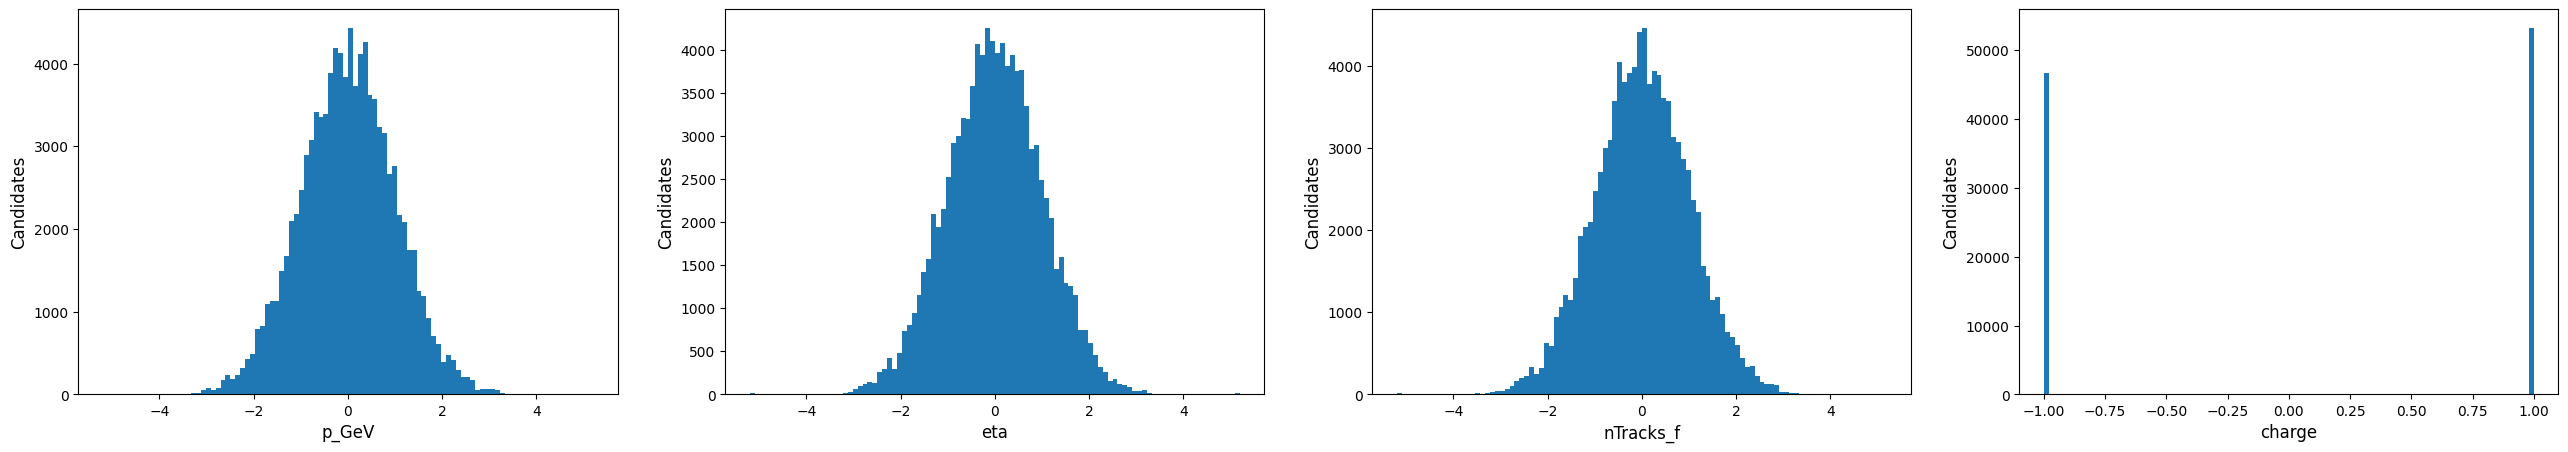

In [38]:
plt.figure(figsize=(32, 5), dpi=100)

for i, x_var in enumerate(conditions):
    plt.subplot(1, 4, i+1)
    plt.xlabel(x_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(X_p[:, i].numpy()[:100000], bins=100)

plt.show()

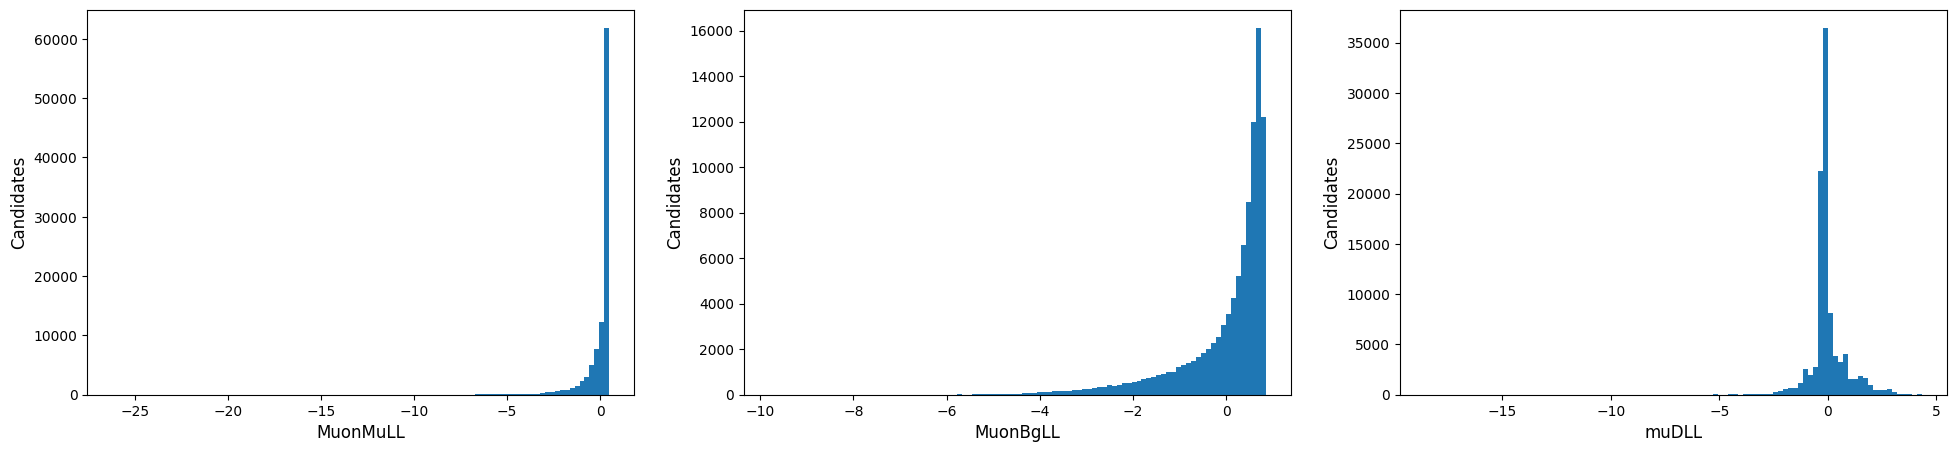

In [39]:
plt.figure(figsize=(24, 5), dpi=100)

for i, y_var in enumerate(target):
    plt.subplot(1, 3, i+1)
    plt.xlabel(y_var, fontsize=12)
    plt.ylabel("Candidates", fontsize=12)
    plt.hist(y_p[:, i].numpy()[:100000], bins=100)

plt.subplot(1, 3, 3)
plt.xlabel("muDLL", fontsize=12)
plt.ylabel("Candidates", fontsize=12)
plt.hist(y_p[:, 0].numpy()[:100000] - y_p[:, 1].numpy()[:100000], bins=100)

plt.show()

In [40]:
np.savez_compressed(
    file=f"{DATA_PATH}/Muon-proton-{SAMPLE}-trainset.npz",
    x=X_p.numpy(),
    x_vars=conditions,
    y=y_p.numpy(),
    y_vars=target,
    w=None,
    w_var=None,
)